### Hyperparameter definition

In [ ]:
# First install ClearML if not already installed: pip install clearml
import clearml
from clearml import Task, Logger

# Initialize ClearML Task
task = Task.init(project_name='DreamBooth Training', task_name='dreambooth_dog',  reuse_last_task_id=False)
logger = Logger.current_logger()

# Define hyperparameters with additional parameters
hyperparameters = {
    'subject_tokens': 'xon',
    'subject_prompt': 'a xon dog',
    'class_prompt': 'a dog',
    'num_prior_images': 1000,
    'learning_rate': 1e-06,
    'num_train_epochs': 1000,
    'prior_batch_size': 7,
    'train_batch_size': 5,
    'use_prior_preservation': True,
    'prior_loss_weight': 1.0,
    'use_dreambooth_prompts': True
}

# Connect hyperparameters to ClearML
task.connect(hyperparameters)

# Unpack parameters directly from dict for cleaner code
subject_identifier = hyperparameters['subject_tokens']
subject_prompt = hyperparameters['subject_prompt']
class_prompt = hyperparameters['class_prompt']
num_prior_images = hyperparameters['num_prior_images']
learning_rate = hyperparameters['learning_rate']
num_train_epochs = hyperparameters['num_train_epochs']
prior_batch_size = hyperparameters['prior_batch_size']
train_batch_size = hyperparameters['train_batch_size']
use_prior_preservation = hyperparameters['use_prior_preservation']
prior_loss_weight = hyperparameters['prior_loss_weight']
use_dreambooth_prompts = hyperparameters['use_dreambooth_prompts']

ClearML Task: overwriting (reusing) task id=5127c6025eaa42dab88caed6b3ec3e30
2025-03-25 18:54:56,080 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/0009581d19764aeaa42308fae5caaa27/experiments/5127c6025eaa42dab88caed6b3ec3e30/output/log


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

### Data loading

In [4]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")

In [5]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, subject_prompt, class_prompt, tokenizer, transforms, use_dreambooth_prompts=True):
        self.image_dir = image_dir
        self.subject_prompt = subject_prompt
        self.class_prompt = class_prompt
        self.tokenizer = tokenizer
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms
        self.use_dreambooth_prompts = use_dreambooth_prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        prompt = self.subject_prompt if self.use_dreambooth_prompts else self.class_prompt
        encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.tokenizer.model_max_length, return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

In [7]:
image_dir = '../data/paper_dataset/dog'
dataset = CustomDataset(image_dir, subject_prompt, class_prompt, tokenizer, train_transforms,)

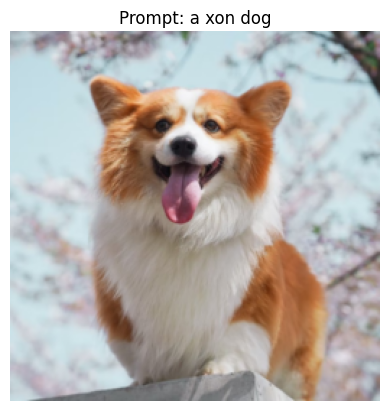

In [8]:
import matplotlib.pyplot as plt
# Function to visualize an image
def visualize_image(dataset, idx):
    image, input_ids, attention_mask = dataset[idx]
    image = image.permute(1, 2, 0)  # Change the order of dimensions for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    image = image.numpy()
    
    plt.imshow(image)
    plt.title(f"Prompt: {dataset.subject_prompt if dataset.use_dreambooth_prompts else dataset.class_prompt}")
    plt.axis('off')
    plt.show()

# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [10]:
train_batch_size = 5
train_dataloader = DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

### Load the diffusion model for tuning

In [11]:
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [12]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
variant = None

In [13]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

In [14]:
import torch
import subprocess

def get_free_gpu():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    free_memory = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return free_memory.index(max(free_memory))

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

### Set Up Prior Preservation Mechanism

In [15]:
use_prior_preservation = True
prior_loss_weight = 1.0  # lambda in the paper

In [ ]:
import matplotlib.pyplot as plt
import torch

if use_prior_preservation:
    
    # Create a frozen copy of the original UNet for generating prior samples.
    unet_pretrained = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, 
                                                           subfolder="unet", revision=revision, variant=variant)
    unet_pretrained.to(device, dtype=weight_dtype)
    unet_pretrained.eval()
    
    # Build a separate pipeline using the frozen UNet.
    pipeline_pretrained = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet_pretrained,
        scheduler=noise_scheduler,
        safety_checker=None,
        feature_extractor=None,
    ).to(device)
    
    # Pre-generate a small set of prior samples.
    num_prior_images = num_prior_images
    batch_size = 64
    prior_latents_list = []
    generated_images = []
    print("Generating prior preservation latents...")
    total_generated = 0
    prior_latents_list = []
    generated_images = []
    
    while total_generated < num_prior_images:
        current_batch_size = min(batch_size, num_prior_images - total_generated)
        print(f"Generating images {total_generated} to {total_generated + current_batch_size - 1}")
        with torch.no_grad(), torch.autocast("cuda"):
            output = pipeline_pretrained([class_prompt] * current_batch_size, num_inference_steps=50, guidance_scale=7.5)
        
        for j in range(current_batch_size):
            gen_image = output.images[j].convert("RGB")
            
            if total_generated + j < 5:
                generated_images.append(gen_image)
            
            gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
            with torch.no_grad():
                latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
            prior_latents_list.append(latent)
        
        total_generated += current_batch_size

In [ ]:
# Prepare prior prompt embeddings 
prior_inputs = tokenizer(class_prompt, return_tensors="pt", max_length=tokenizer.model_max_length,
                            padding="max_length", truncation=True)
prior_input_ids = prior_inputs["input_ids"].to(device)
prior_attention_mask = prior_inputs["attention_mask"].to(device)
with torch.no_grad():
    prior_embeddings = text_encoder(input_ids=prior_input_ids, attention_mask=prior_attention_mask).last_hidden_state

In [ ]:
import torch
prior_latents_tensor = torch.cat(prior_latents_list, dim=0)
torch.save(prior_latents_tensor, '../data/prior_imgs/dog/prior_latents_tensor.pt')
torch.save(prior_embeddings, '../data/prior_imgs/dog/prior_embeddings.pt')
torch.save(prior_attention_mask, '../data/prior_imgs/dog/prior_attention_mask.pt')

### Set Up Training Hyperparameters & Optimizer

In [16]:
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(vae.parameters()) + list(text_encoder.parameters()),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

In [17]:
# Use total steps based on dataset size (using custom_dataset length)
num_training_steps = num_train_epochs * len(dataset) // train_batch_size
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

### Set up the prior_dataloader

In [ ]:
# Load the tensor from the file
prior_latents_tensor = torch.load('../data/prior_imgs/dog/prior_latents_tensor_v2.pt')
prior_embeddings = torch.load('../data/prior_imgs/dog/prior_embeddings.pt')
prior_attention_mask = torch.load('../data/prior_imgs/dog/prior_attention_mask.pt')

In [ ]:
prior_embeddings.shape

In [ ]:
prior_latents_tensor.shape

In [ ]:
prior_attention_mask.shape

In [ ]:
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=prior_batch_size, shuffle=True)

### Model tuning

In [18]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [20]:
# Prepare prior text embeddings once before training
with torch.no_grad():
    prior_inputs = tokenizer(
        class_prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    prior_outputs = text_encoder(
        input_ids=prior_inputs["input_ids"],
        attention_mask=prior_inputs["attention_mask"]
    )
    prior_embeddings = prior_outputs.last_hidden_state
    prior_attention_mask = prior_inputs["attention_mask"]

In [21]:
# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    vae.train()
    text_encoder.train()
    
    epoch_losses = []

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

        # Sample noise and timesteps for subject images
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss with on-the-fly generation -----
        if use_prior_preservation:
            # Determine batch size for prior samples (same as subject batch size)
            prior_batch_size = latents.shape[0]
            
            # Generate prior samples on-the-fly using the frozen pipeline
            with torch.no_grad(), torch.autocast("cuda"):
                prior_output = pipeline(
                    [class_prompt] * prior_batch_size, 
                    num_inference_steps=30,  # Reduced steps for faster training
                    guidance_scale=7.5
                )
            
            # Process generated images to latents
            prior_batch = []
            for j in range(prior_batch_size):
                gen_image = prior_output.images[j].convert("RGB")
                gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
                
                with torch.no_grad():
                    prior_latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
                prior_batch.append(prior_latent)
            
            # Stack latents into a batch
            prior_batch = torch.cat(prior_batch, dim=0)

            # For the prior branch, sample noise and timesteps
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                    (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Expand prior embeddings to match batch size
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch
            model_pred_prior = unet(noisy_prior_latents, t_prior, 
                                   encoder_hidden_states=prior_embeddings_expanded,
                                   encoder_attention_mask=prior_attention_mask_expanded, 
                                   return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + prior_loss_weight * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    # Log metrics
    logger.report_scalar(
        title="Training Metrics", 
        series="Loss", 
        value=avg_loss, 
        iteration=epoch
    )
    logger.report_scalar(
        title="Training Metrics",
        series="Learning Rate",
        value=lr_scheduler.get_last_lr()[0],
        iteration=epoch
    )
    
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")
    # Periodic image generation and logging
    if epoch % 100 == 0:
        with torch.no_grad():
            test_image = pipeline(subject_prompt, num_inference_steps=100).images[0]
            logger.report_image(
                title="Sample Outputs",
                series=f"Epoch {epoch}",
                image=test_image,
                iteration=epoch
            )

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/1000, Loss: 0.5403


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 1/1000 [00:11<3:06:12, 11.18s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 2/1000 [00:14<1:51:38,  6.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 3/1000 [00:18<1:27:44,  5.28s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 4/1000 [00:21<1:16:31,  4.61s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 5/1000 [00:25<1:10:19,  4.24s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 6/1000 [00:29<1:06:36,  4.02s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 7/1000 [00:32<1:04:15,  3.88s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 8/1000 [00:36<1:02:42,  3.79s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 9/1000 [00:39<1:01:38,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 10/1000 [00:43<1:00:53,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 11/1000 [00:47<1:00:22,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|          | 12/1000 [00:50<1:00:00,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|▏         | 13/1000 [00:54<1:00:36,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   1%|▏         | 14/1000 [00:58<1:00:15,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 15/1000 [01:01<1:00:06,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 16/1000 [01:05<59:56,  3.66s/it]  

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 17/1000 [01:09<59:53,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 18/1000 [01:12<59:58,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 19/1000 [01:16<59:49,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 20/1000 [01:20<59:34,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 21/1000 [01:23<59:33,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 22/1000 [01:27<59:35,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 23/1000 [01:31<59:39,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▏         | 24/1000 [01:34<59:39,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   2%|▎         | 25/1000 [01:38<59:32,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 26/1000 [01:41<59:24,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 27/1000 [01:45<59:23,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 28/1000 [01:49<59:20,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 29/1000 [01:52<59:16,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 30/1000 [01:56<59:14,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 31/1000 [02:00<59:16,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 32/1000 [02:04<59:12,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 33/1000 [02:07<58:57,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 34/1000 [02:11<58:47,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▎         | 35/1000 [02:14<58:57,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▎         | 36/1000 [02:18<59:02,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▎         | 37/1000 [02:22<59:02,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 38/1000 [02:26<1:01:04,  3.81s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 39/1000 [02:30<1:00:12,  3.76s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 40/1000 [02:33<59:36,  3.73s/it]  

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 41/1000 [02:37<59:07,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 42/1000 [02:41<58:48,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 43/1000 [02:44<58:37,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 44/1000 [02:48<58:31,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   4%|▍         | 45/1000 [02:52<58:19,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▍         | 46/1000 [02:55<58:08,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▍         | 47/1000 [02:59<58:00,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▍         | 48/1000 [03:02<57:52,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▍         | 49/1000 [03:06<58:21,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▌         | 50/1000 [03:10<58:15,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▌         | 51/1000 [03:14<58:03,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▌         | 52/1000 [03:17<57:56,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▌         | 53/1000 [03:21<57:42,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   5%|▌         | 54/1000 [03:24<57:33,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 55/1000 [03:28<57:27,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 56/1000 [03:32<57:23,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 57/1000 [03:35<57:18,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 58/1000 [03:39<57:12,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 59/1000 [03:43<57:08,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 60/1000 [03:46<57:06,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 61/1000 [03:50<57:06,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▌         | 62/1000 [03:54<57:03,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▋         | 63/1000 [03:57<56:59,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▋         | 64/1000 [04:01<56:51,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   6%|▋         | 65/1000 [04:05<56:49,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 66/1000 [04:08<56:44,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 67/1000 [04:12<56:57,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 68/1000 [04:16<56:47,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 69/1000 [04:19<56:41,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 70/1000 [04:23<56:38,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 71/1000 [04:27<56:42,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 72/1000 [04:30<56:53,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 73/1000 [04:34<56:43,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   7%|▋         | 74/1000 [04:38<56:33,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 75/1000 [04:41<56:27,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 76/1000 [04:45<56:19,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 77/1000 [04:48<56:11,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 78/1000 [04:52<56:03,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 79/1000 [04:56<56:00,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 80/1000 [04:59<55:56,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 81/1000 [05:03<55:55,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 82/1000 [05:07<56:04,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 83/1000 [05:10<56:02,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 84/1000 [05:14<55:55,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   8%|▊         | 85/1000 [05:18<55:51,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▊         | 86/1000 [05:21<55:44,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▊         | 87/1000 [05:25<55:44,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 88/1000 [05:29<55:42,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 89/1000 [05:32<55:38,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 90/1000 [05:36<55:31,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 91/1000 [05:40<55:28,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 92/1000 [05:43<55:23,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 93/1000 [05:47<55:18,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   9%|▉         | 94/1000 [05:51<55:24,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|▉         | 95/1000 [05:54<55:16,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|▉         | 96/1000 [05:58<55:07,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|▉         | 97/1000 [06:02<55:18,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|▉         | 98/1000 [06:05<55:18,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|▉         | 99/1000 [06:09<55:42,  3.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|█         | 100/1000 [06:13<55:22,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 101/1000, Loss: 0.2006


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:  10%|█         | 101/1000 [06:24<1:29:51,  6.00s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|█         | 102/1000 [06:28<1:19:13,  5.29s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|█         | 103/1000 [06:32<1:11:42,  4.80s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|█         | 104/1000 [06:35<1:06:27,  4.45s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  10%|█         | 105/1000 [06:39<1:02:49,  4.21s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 106/1000 [06:42<1:00:14,  4.04s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 107/1000 [06:46<58:25,  3.93s/it]  

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 108/1000 [06:50<57:09,  3.84s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 109/1000 [06:53<56:11,  3.78s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 110/1000 [06:57<55:29,  3.74s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 111/1000 [07:01<54:57,  3.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█         | 112/1000 [07:04<54:35,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█▏        | 113/1000 [07:08<54:21,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  11%|█▏        | 114/1000 [07:12<54:16,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 115/1000 [07:15<54:08,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 116/1000 [07:19<53:54,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 117/1000 [07:23<53:48,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 118/1000 [07:26<53:42,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 119/1000 [07:30<53:35,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 120/1000 [07:34<53:28,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 121/1000 [07:37<53:22,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 122/1000 [07:41<53:18,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 123/1000 [07:44<53:11,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▏        | 124/1000 [07:48<53:05,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  12%|█▎        | 125/1000 [07:52<53:02,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 126/1000 [07:55<53:00,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 127/1000 [07:59<52:53,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 128/1000 [08:03<52:51,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 129/1000 [08:06<52:46,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 130/1000 [08:10<52:43,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 131/1000 [08:14<52:38,  3.63s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 132/1000 [08:17<52:32,  3.63s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 133/1000 [08:21<52:31,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  13%|█▎        | 134/1000 [08:24<52:28,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▎        | 135/1000 [08:28<52:30,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▎        | 136/1000 [08:32<52:26,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▎        | 137/1000 [08:35<52:23,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 138/1000 [08:39<52:22,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 139/1000 [08:43<52:17,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 140/1000 [08:46<52:18,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 141/1000 [08:50<52:14,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 142/1000 [08:54<52:11,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 143/1000 [08:57<52:04,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 144/1000 [09:01<52:01,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  14%|█▍        | 145/1000 [09:05<51:57,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▍        | 146/1000 [09:08<51:55,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▍        | 147/1000 [09:12<51:50,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▍        | 148/1000 [09:15<51:45,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▍        | 149/1000 [09:19<52:06,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 150/1000 [09:23<51:56,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 151/1000 [09:27<51:44,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 152/1000 [09:30<51:35,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 153/1000 [09:34<51:29,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 154/1000 [09:37<51:23,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 155/1000 [09:41<51:18,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 156/1000 [09:45<51:13,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 157/1000 [09:48<51:08,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 158/1000 [09:52<51:03,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 159/1000 [09:56<50:59,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 160/1000 [09:59<50:53,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 161/1000 [10:03<50:56,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▌        | 162/1000 [10:07<50:51,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▋        | 163/1000 [10:10<50:46,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▋        | 164/1000 [10:14<50:43,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  16%|█▋        | 165/1000 [10:17<50:38,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 166/1000 [10:21<50:59,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 167/1000 [10:25<51:01,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 168/1000 [10:29<50:51,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 169/1000 [10:32<50:47,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 170/1000 [10:36<51:20,  3.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 171/1000 [10:40<50:59,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 172/1000 [10:43<50:43,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 173/1000 [10:47<50:32,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  17%|█▋        | 174/1000 [10:51<50:24,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 175/1000 [10:54<50:16,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 176/1000 [10:58<50:11,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 177/1000 [11:02<50:04,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 178/1000 [11:05<50:00,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 179/1000 [11:09<49:56,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 180/1000 [11:12<49:49,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 181/1000 [11:16<49:43,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 182/1000 [11:20<49:38,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 183/1000 [11:23<49:32,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 184/1000 [11:27<49:27,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  18%|█▊        | 185/1000 [11:31<49:23,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▊        | 186/1000 [11:34<49:20,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▊        | 187/1000 [11:38<49:16,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 188/1000 [11:42<49:12,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 189/1000 [11:45<49:08,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 190/1000 [11:49<49:05,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 191/1000 [11:52<49:03,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 192/1000 [11:56<48:59,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 193/1000 [12:00<48:56,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  19%|█▉        | 194/1000 [12:03<48:54,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|█▉        | 195/1000 [12:07<48:52,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|█▉        | 196/1000 [12:11<49:04,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|█▉        | 197/1000 [12:14<48:55,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|█▉        | 198/1000 [12:18<48:51,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|█▉        | 199/1000 [12:22<49:09,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|██        | 200/1000 [12:25<48:54,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 201/1000, Loss: 0.3508


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:  20%|██        | 201/1000 [12:37<1:19:30,  5.97s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|██        | 202/1000 [12:40<1:10:11,  5.28s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|██        | 203/1000 [12:44<1:03:34,  4.79s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|██        | 204/1000 [12:48<58:56,  4.44s/it]  

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  20%|██        | 205/1000 [12:51<55:44,  4.21s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 206/1000 [12:55<53:24,  4.04s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 207/1000 [12:59<51:47,  3.92s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 208/1000 [13:02<50:38,  3.84s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 209/1000 [13:06<49:50,  3.78s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 210/1000 [13:10<49:14,  3.74s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 211/1000 [13:13<48:46,  3.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██        | 212/1000 [13:17<48:25,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██▏       | 213/1000 [13:21<48:19,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  21%|██▏       | 214/1000 [13:24<48:11,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 215/1000 [13:28<47:56,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 216/1000 [13:31<47:46,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 217/1000 [13:35<47:39,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 218/1000 [13:39<47:35,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 219/1000 [13:42<47:28,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 220/1000 [13:46<47:25,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 221/1000 [13:50<47:18,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 222/1000 [13:53<47:16,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 223/1000 [13:57<47:12,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▏       | 224/1000 [14:01<47:10,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  22%|██▎       | 225/1000 [14:04<47:04,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 226/1000 [14:08<46:59,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 227/1000 [14:12<46:54,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 228/1000 [14:15<46:51,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 229/1000 [14:19<46:46,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 230/1000 [14:22<46:45,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 231/1000 [14:26<46:43,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 232/1000 [14:30<46:43,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 233/1000 [14:33<46:46,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  23%|██▎       | 234/1000 [14:37<46:38,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▎       | 235/1000 [14:41<46:34,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▎       | 236/1000 [14:44<46:27,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▎       | 237/1000 [14:48<46:24,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 238/1000 [14:52<46:19,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 239/1000 [14:55<46:15,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 240/1000 [14:59<46:08,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 241/1000 [15:03<46:02,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 242/1000 [15:06<45:59,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 243/1000 [15:10<45:54,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 244/1000 [15:14<45:49,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  24%|██▍       | 245/1000 [15:17<45:49,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▍       | 246/1000 [15:21<45:46,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▍       | 247/1000 [15:24<45:49,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▍       | 248/1000 [15:28<46:09,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▍       | 249/1000 [15:32<45:53,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 250/1000 [15:36<45:42,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 251/1000 [15:39<45:34,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 252/1000 [15:43<46:37,  3.74s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 253/1000 [15:47<47:26,  3.81s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 254/1000 [15:51<46:55,  3.77s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 255/1000 [15:54<46:21,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 256/1000 [15:58<46:10,  3.72s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 257/1000 [16:02<45:49,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 258/1000 [16:05<45:32,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 259/1000 [16:09<45:20,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 260/1000 [16:13<45:11,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 261/1000 [16:16<45:05,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▌       | 262/1000 [16:20<45:03,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▋       | 263/1000 [16:24<44:56,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▋       | 264/1000 [16:28<45:38,  3.72s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  26%|██▋       | 265/1000 [16:31<45:19,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 266/1000 [16:35<45:02,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 267/1000 [16:38<44:54,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 268/1000 [16:42<44:58,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 269/1000 [16:46<44:45,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 270/1000 [16:49<44:32,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 271/1000 [16:53<44:21,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 272/1000 [16:57<44:16,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 273/1000 [17:00<44:09,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  27%|██▋       | 274/1000 [17:04<44:44,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 275/1000 [17:08<44:52,  3.71s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 276/1000 [17:12<44:31,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 277/1000 [17:15<44:56,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 278/1000 [17:19<45:44,  3.80s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 279/1000 [17:23<45:24,  3.78s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 280/1000 [17:27<45:12,  3.77s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 281/1000 [17:30<44:40,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 282/1000 [17:34<44:19,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 283/1000 [17:38<44:04,  3.69s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 284/1000 [17:41<43:50,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  28%|██▊       | 285/1000 [17:45<43:39,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▊       | 286/1000 [17:49<43:30,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▊       | 287/1000 [17:52<43:22,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 288/1000 [17:56<43:16,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 289/1000 [18:00<43:09,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 290/1000 [18:03<43:06,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 291/1000 [18:07<43:01,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 292/1000 [18:10<42:57,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 293/1000 [18:14<42:53,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  29%|██▉       | 294/1000 [18:18<42:47,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|██▉       | 295/1000 [18:21<42:44,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|██▉       | 296/1000 [18:25<42:40,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|██▉       | 297/1000 [18:29<42:37,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|██▉       | 298/1000 [18:32<43:01,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|██▉       | 299/1000 [18:36<42:49,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|███       | 300/1000 [18:40<42:41,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 301/1000, Loss: 0.2592


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:  30%|███       | 301/1000 [18:51<1:09:22,  5.96s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|███       | 302/1000 [18:55<1:01:12,  5.26s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|███       | 303/1000 [18:58<55:30,  4.78s/it]  

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|███       | 304/1000 [19:02<51:29,  4.44s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  30%|███       | 305/1000 [19:06<48:35,  4.20s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 306/1000 [19:09<46:36,  4.03s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 307/1000 [19:13<45:11,  3.91s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 308/1000 [19:17<44:13,  3.83s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 309/1000 [19:20<43:26,  3.77s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 310/1000 [19:24<42:53,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 311/1000 [19:27<42:29,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███       | 312/1000 [19:31<42:09,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███▏      | 313/1000 [19:35<41:59,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  31%|███▏      | 314/1000 [19:38<41:49,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 315/1000 [19:42<41:57,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 316/1000 [19:46<41:51,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 317/1000 [19:49<41:40,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 318/1000 [19:53<41:30,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 319/1000 [19:57<41:23,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 320/1000 [20:00<41:17,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 321/1000 [20:04<41:13,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 322/1000 [20:08<41:06,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 323/1000 [20:11<41:02,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▏      | 324/1000 [20:15<41:00,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  32%|███▎      | 325/1000 [20:18<40:57,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 326/1000 [20:22<40:54,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 327/1000 [20:26<40:59,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 328/1000 [20:29<41:03,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 329/1000 [20:33<40:55,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 330/1000 [20:37<40:48,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 331/1000 [20:40<40:44,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 332/1000 [20:44<40:40,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 333/1000 [20:48<40:39,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  33%|███▎      | 334/1000 [20:51<40:32,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▎      | 335/1000 [20:55<40:29,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▎      | 336/1000 [20:59<40:23,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▎      | 337/1000 [21:02<40:19,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 338/1000 [21:06<40:16,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 339/1000 [21:10<40:13,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 340/1000 [21:13<40:10,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 341/1000 [21:17<40:05,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 342/1000 [21:21<40:02,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 343/1000 [21:24<40:00,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 344/1000 [21:28<39:58,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  34%|███▍      | 345/1000 [21:32<39:53,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▍      | 346/1000 [21:35<39:47,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▍      | 347/1000 [21:39<39:41,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▍      | 348/1000 [21:43<39:59,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▍      | 349/1000 [21:46<39:48,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 350/1000 [21:50<39:39,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 351/1000 [21:54<39:34,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 352/1000 [21:57<39:33,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 353/1000 [22:01<39:25,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 354/1000 [22:04<39:19,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 355/1000 [22:08<39:15,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 356/1000 [22:12<39:11,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 357/1000 [22:15<39:07,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 358/1000 [22:19<39:02,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 359/1000 [22:23<38:56,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 360/1000 [22:26<38:53,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 361/1000 [22:30<38:46,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▌      | 362/1000 [22:34<38:44,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▋      | 363/1000 [22:37<38:41,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▋      | 364/1000 [22:41<38:37,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  36%|███▋      | 365/1000 [22:45<38:32,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 366/1000 [22:48<38:29,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 367/1000 [22:52<38:24,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 368/1000 [22:55<38:22,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 369/1000 [22:59<38:18,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 370/1000 [23:03<38:16,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 371/1000 [23:06<38:12,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 372/1000 [23:10<38:08,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 373/1000 [23:14<38:03,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  37%|███▋      | 374/1000 [23:17<37:58,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 375/1000 [23:21<37:55,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 376/1000 [23:25<37:58,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 377/1000 [23:28<37:55,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 378/1000 [23:32<37:50,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 379/1000 [23:36<37:45,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 380/1000 [23:39<37:39,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 381/1000 [23:43<37:41,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 382/1000 [23:47<37:32,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 383/1000 [23:50<37:25,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 384/1000 [23:54<37:24,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  38%|███▊      | 385/1000 [23:57<37:22,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▊      | 386/1000 [24:01<37:18,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▊      | 387/1000 [24:05<37:13,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 388/1000 [24:08<37:07,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 389/1000 [24:12<37:04,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 390/1000 [24:16<37:03,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 391/1000 [24:19<36:58,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 392/1000 [24:23<36:55,  3.64s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 393/1000 [24:27<36:52,  3.65s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  39%|███▉      | 394/1000 [24:30<37:01,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|███▉      | 395/1000 [24:34<37:04,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|███▉      | 396/1000 [24:38<36:56,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|███▉      | 397/1000 [24:41<36:46,  3.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|███▉      | 398/1000 [24:45<37:06,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|███▉      | 399/1000 [24:49<36:54,  3.68s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|████      | 400/1000 [24:52<36:42,  3.67s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 401/1000, Loss: 0.1737


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:  40%|████      | 401/1000 [25:04<59:30,  5.96s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|████      | 402/1000 [25:07<52:27,  5.26s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|████      | 403/1000 [25:11<47:30,  4.78s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|████      | 404/1000 [25:15<44:03,  4.44s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  40%|████      | 405/1000 [25:18<41:44,  4.21s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 406/1000 [25:22<40:00,  4.04s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 407/1000 [25:26<38:43,  3.92s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 408/1000 [25:29<37:49,  3.83s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 409/1000 [25:33<37:09,  3.77s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 410/1000 [25:36<36:41,  3.73s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 411/1000 [25:40<36:20,  3.70s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

Epochs:  41%|████      | 411/1000 [25:42<36:50,  3.75s/it]


KeyboardInterrupt: 

### Inference: Generate Images using the Fine-Tuned Model

In [22]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Check only the subject_prompt without additional stylization

In [23]:
# Final image logging
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    logger.report_image(
        title="Final Outputs",
        series=f"Image {idx}",
        image=img,
        iteration=num_train_epochs
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
task.close()

In [26]:
subject_prompt

'a xon dog'

  0%|          | 0/100 [00:00<?, ?it/s]

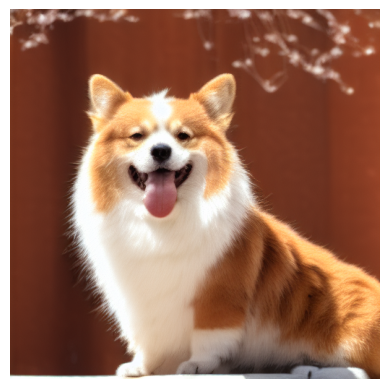

In [27]:
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"target_generated_image_{idx}.png")

### Check the subject_prompt with additional stylization

In [28]:
prompt = "sad " + subject_prompt

In [29]:
prompt

'sad a xon dog'

  0%|          | 0/100 [00:00<?, ?it/s]

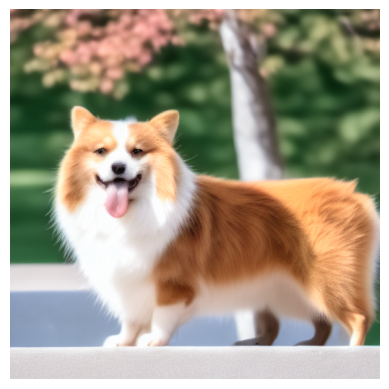

In [30]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{0}.png")


In [31]:
prompt = subject_prompt + " in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring."

In [32]:
prompt

'a xon dog in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring.'

  0%|          | 0/100 [00:00<?, ?it/s]

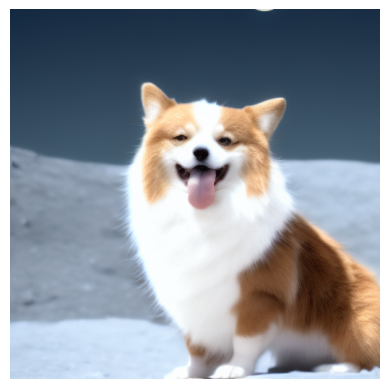

In [33]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{1}.png")


In [34]:
prompt = subject_prompt + " in cool sunglasses sitting in the sport car, smillings and have good time"

In [35]:
prompt 

'a xon dog in cool sunglasses sitting in the sport car, smillings and have good time'

  0%|          | 0/200 [00:00<?, ?it/s]

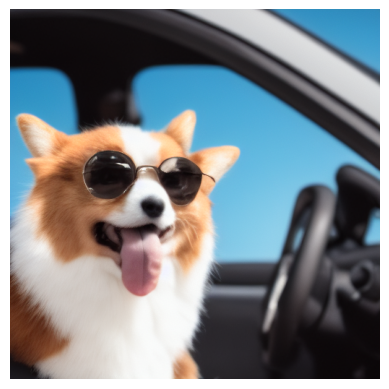

In [36]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=200, guidance_scale=4.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{2}.png")
